NOTE: Choose a value of axion mass 'm_a' in the cell below the next one to generate a mass function curve. If you need to save the generated graph, set 'save_file = True'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import simpson
import scipy.integrate as si
import pickle
import seaborn as sns
import scipy.optimize as so
import os
import requests
# import sympy as sp


In [2]:
# PARAMETERS

# m_a = 1.25  # measured in micro eV
m_a = 25  # measured in micro eV
# m_a = 500  # measured in micro eV

save_file = False  # save the plot or not

In [3]:
with open(r'..\Data\SF interpolator.pickle', 'rb') as f:
    # Read out object  from file
    rgi = pickle.load(f)  #interpolation function for our SF(Efrac, c). 

In [4]:
rgi(np.array([[1e2, 100], [1e0, 100]])) #Efrac, c

array([0.22606943, 0.61536183])

In [5]:
# Set up mass-concentration relationship
if m_a == 1.25:
    with open(r'..\Data\mass_conc_1p25_mueV_interpolator.pkl', 'rb') as file:
        concentration_mass_interpolator = pickle.load(file)
elif m_a == 25:
    with open(r'..\Data\mass_conc_25_mueV_interpolator.pkl', 'rb') as file:
        concentration_mass_interpolator = pickle.load(file)
elif m_a == 500:
    with open(r'..\Data\mass_conc_500_mueV_interpolator.pkl', 'rb') as file:
        concentration_mass_interpolator = pickle.load(file)
else:
    raise ValueError("For axion mass 'm_a', please choose from one of the following values in units of mueV: 1.25, 25, 500")
# To use the above interpolator, pass as argument the mass of minihalo. The interpolator will output 'concentration X (1 + infall_redshift)'

# Set up collpase fraction and derivative of colapse functions relationship with respect ot redhsift
with open(r'..\Data\collapse_fraction_interpolation_wrong_Mmin.pickle', 'rb') as f: #Mmin=1e-2 
    get_collapse_fraction = pickle.load(f)

# with open(r'C:\Users\ids29\Dropbox\UC PhD\Derivations\Scripts\collapse_fraction_interpolation.pickle', 'rb') as f: 
#     get_collapse_fraction = pickle.load(f) #is using S2023 Mmin=1e2

with open(r'..\Data\derivative_of_collapse_fraction_interpolation_wrong_Mmin.pickle', 'rb') as f:
    get_derivative_of_collapse_fraction = pickle.load(f) #Mmin=1e-2 

# with open(r'C:\Users\ids29\Dropbox\UC PhD\Derivations\Scripts\derivative_of_collapse_fraction_interpolation.pickle', 'rb') as f:
#     get_derivative_of_collapse_fraction = pickle.load(f) #is using S2023 Mmin=1e2

# Set up isocurvature growth function: Input: redshift; Output: Isocurvature gorwth factor
with open(r'..\Data\growth_function.pickle', 'rb') as f:
    get_isocurvature_growth_factor = pickle.load(f)

# Get matter denisty today
rho_m_today = np.load(r"..\Data\rho_matter_today.npy")

# # Get cold dark matter density today
# rho_cdm_today = np.load(r"rho_cdm_today.npy")

# Load the Sigmas_star array which has data type = object. It contains 1e6 1-dim numpy arrays, each corresponding to a given orbit generated by the Monte Carlo algorithm
# Each 1-dim numpy array consists of the effective stellar surface densities corresponding to given MW disk passes by the minhalo 
# REMEMBER that Sigma_star is got from lbparticles code which calculates it in units of solar masses / pc^2. This must be changed to solar masses / m^2 to use in this Jupyter notebook.
file_url = 'https://github.com/ian-dsouza/axion-minihalos-2/releases/download/Data/Sigmas_star_uptill_zi.pkl'
local_filename = 'Sigmas_star_uptill_zi.pkl'

if not os.path.exists(local_filename):
    print(f'Downloading {local_filename}...')
    response = requests.get(file_url)
    with open(local_filename, 'wb') as f:
        f.write(response.content)
    print('Download complete.')
else:
    print(f'{local_filename} already exists.')

# Proceed to load the pickle file
import pickle
with open(local_filename, 'rb') as f:
    Sigmas_star_all_orbits = pickle.load(f) # measured in solar masses / pc^2

# Load the flags. Flags is a 2 rows X 1e6 columns numpy array.
# If flag[index, 0] = 1, the first disk pass for that orbit given by 'index' is a partial disk crossing. When calculating b_c, we must use the average Sigma_star (effective stellar surface density) for a disk crossing
# If flag[index, 1] = 1, the last disk pass for that orbit given by 'index' is a partial disk crossing. When calculating b_c, we must use the average Sigma_star (effective stellar surface density) for a disk crossing
flags_bc = np.load(r'..\Data\flags_double_bc_uptill_zi.npy')


# Load the time stamps of of stellar encounters (effective disk passes) for the during of a given orbit, for all orbits.
# It is of the form: np.empty((1e6,), dtype=object)
file_url = 'https://github.com/ian-dsouza/axion-minihalos-2/releases/download/Data_2/time_stamps_uptill_zi.pkl'
local_filename = 'time_stamps_uptill_zi.pkl'

if not os.path.exists(local_filename):
    print(f'Downloading {local_filename}...')
    response = requests.get(file_url)
    with open(local_filename, 'wb') as f:
        f.write(response.content)
    print('Download complete.')
else:
    print(f'{local_filename} already exists.')

# Proceed to load the pickle file
with open(local_filename, 'rb') as f:
    times_stamp_encounter_all_orbits = pickle.load(f)

Download complete.
Download complete.


In [87]:
delta_c = 1.686
A_osc = 0.1
M_0 = 2.3e-10 * (50 / m_a)**0.51  # measured in solar masses
k = np.sqrt(3 * A_osc * M_0 / (2 * np.pi**2))

A = 0.374
p = 0.19
q = 1.2

def pre_infall_mass_function(M, z):
    D1_z = get_isocurvature_growth_factor(z)

    dnu_dM = delta_c**2 / (D1_z**2 * k**2)
    sigma = D1_z * k / np.sqrt(M)
    nu = delta_c**2 / sigma**2
    f_of_nu = A * ( 1 + (q * nu)**(-p) ) * np.sqrt( q / (2 * np.pi * nu) ) * np.exp(- q * nu / 2)
    return rho_m_today / M * f_of_nu * dnu_dM

In [88]:
eta = 0.987
a1 = -0.8
a2 = -0.586
a3 = -0.034
b0 = -0.583
b1 = -0.559

# S2023's empirical fitting function 
def survival_fractionS2023(Efrac, c): 
    p = 10**( a1*(np.log10(c) - eta) + a2*(np.log10(c) - eta)**2 + a3*(np.log10(c) - eta)**3 )
    k = 10**( b0 + b1*(np.log10(c) - 2) )  
    survival_fraction = 2 / ( 1+ (1 + Efrac/p)**k )
    return survival_fraction

In [89]:
# Output is concentration
def get_concentration_from_mass(mass, z_i):
    c_times_1PlusZi =  concentration_mass_interpolator(mass)
    
    return c_times_1PlusZi / (1 + z_i)

In [ ]:
num_zi_samples = int(1e3) + 1 # So that the M X z_i gird will be 1,000 X 1,000
num_mass_samples = int(1e3)

zi_min = 0
zi_max = 150
one_plus_zs_i = np.geomspace(1 + zi_min, 1 + zi_max, num_zi_samples)
zs_i_grid = one_plus_zs_i - 1
Delta_zs_i = zs_i_grid[1:] - zs_i_grid[0:-1] # interval between two consecutive values of z_i in zs_i array

# probs_infall = abs(get_derivative_of_collapse_fraction(zs_i_grid[0:-1]))  *  Delta_zs_i # absolute value is taken because derivative of collapse fraction with respect to z_i is negative and probabilities can't be negative.
probs_infall = abs(get_derivative_of_collapse_fraction(zs_i_grid[0:-1]))  *  Delta_zs_i # absolute value is taken because derivative of collapse fraction with respect to z_i is negative and probabilities can't be negative.

M_min = 1e-14 #1.0403991770513538e-12 # measured in solar masses
M_max = 1e-3 #8.026015608726264e-06 # measured in solar masses
masses_grid = np.geomspace(M_min, M_max, num_mass_samples)

number_densities = np.zeros([num_zi_samples - 1, num_mass_samples])
# weights = np.zeros([num_zi_samples - 1, num_mass_samples])
weights = np.zeros([num_zi_samples - 1, num_mass_samples])
for i, z_i in enumerate(zs_i_grid[0:-1]):
    number_densities[i, :] = pre_infall_mass_function(masses_grid, np.repeat(z_i, num_mass_samples))
    # weights[i, :] = number_densities[i, :] * np.repeat(probs_infall[i], num_mass_samples) #X2021 eq 5 with second term neglegted, Mmin=1e-2 solar masses for the collapse fraction
    weights[i, :] = number_densities[i, :] * np.repeat(probs_infall[i], num_mass_samples) #Mmin=1e2 solar masses for the collapse fraction



# Compute concentrations
concentrations = np.zeros([num_zi_samples - 1, num_mass_samples])
for i, z_i in enumerate(zs_i_grid[0:-1]):
    for j, mass in enumerate(masses_grid):
        concentrations[i, j] = get_concentration_from_mass(mass, z_i)

In [91]:
def compute_fNFW(x):
    return np.log(1 + x) - x / (1 + x)

In [92]:
# Compute the average E_frac during the Hubble time (life time of the minihalo)
# For a given orbit, we simply add the E_frac values corresponding to each disk pass to get the net E_frac for that orbit.
# We find the average of net E_fracs corresponding to all orbits generated by the Mopnte Carlo algorithm

##### Parameters
# Length - pc
# Mass - solar masses
# Time - Myr

G_SIunits = 6.6743e-11 # mesaured in SI units
# r_obs_kpc = 8 #measured in kpc - at solar neighborhood in MW galaxy
m_K = 0.6 # measured in solar masses
sigma_star_squared_plus_v_mh_squared_km_s = 250**2 # measured in km^2 / s^2
f_b = 6
Delta_c = 200

Omega_rad = 8.6113e-5
Omega_m = 0.2814
Omega_lambda = 0.7186
H0_usual_units = 69.7 # measured in km/s/Mpc

# Convert above dimensional quantities to pc, solar masses, Myr
G = G_SIunits * (3.24078e-17)**3 / 5.02785e-31 / (3.17098e-8 * 1e-6)**2 # measured in pc^3 / solar masses / Myr^2
sigma_star_squared_plus_v_mh_squared = sigma_star_squared_plus_v_mh_squared_km_s * (3.24078e-14)**2 / (3.17098e-8 * 1e-6)**2 # measured in pc^2 / Myr^2
H0 = H0_usual_units * 3.24078e-20 / (3.17098e-8 * 1e-6) # measured in Myr^(-1)



In [93]:
def group_disk_passes_compare_to_dynamical_time(times_stamp,Es_frac, time_dynamical): # This function groups Efracs based on if the difference between two disk passes is less than the dynamical time of the minihalo
# Inputs: 1) Time stamps of all effective disk passes
#         2) E_frac values of all effective disk passes
#         3) Dynamical time of minihalo
# Output: subsets of the 'Es_frac' array such that each element in a given subset differs from its neighbour by less than a dynamical time

    threshold = time_dynamical

    # Initialize the list of subsets and the first subset
    subsets = []
    current_subset = [Es_frac[0]]

    # Iterate through the ''times_stamp' of 'Es_frac' array starting from the second element
    for i in range(1, len(times_stamp)):
        if times_stamp[i] - times_stamp[i - 1] <= threshold:
            current_subset.append(Es_frac[i])
        else:
            subsets.append(np.array(current_subset))
            current_subset = [Es_frac[i]]

    # Append the last subset
    subsets.append(np.array(current_subset))

    return subsets

In [94]:
def add_Efracs_non_linearly(Es_frac_groups):# Es_frac_groups contains groups of E_frac values such that all members of the same group occur within a dynamical time of their neighbour within the group
    Es_frac_interiorly_added_groups = np.zeros(len(Es_frac_groups)) # Will contain effective Efrac wihtin a group - got by linearlly adding Efracs within the same group

    for i in range(len(Es_frac_groups)):
        Es_frac_interiorly_added_groups[i] = Es_frac_groups[i].sum() # linearly add the Efracs within a group
    
    p = 1 # this is the power in 'E_frac_eff^{p/2}  =  sum of (E_frac_i^{p/2})'
    E_frac_eff_power_pBy2 = np.sum(Es_frac_interiorly_added_groups**(p/2))
    E_frac_eff = E_frac_eff_power_pBy2**(2/p)

    return E_frac_eff


In [ ]:
E_frac_total_2Dgrid = np.zeros([num_zi_samples - 1, num_mass_samples]) # use for the S2023 case
# E_frac_total_2Dgrid_new = np.zeros([num_zi_samples - 1, num_mass_samples]) #will be used for the 1e2 case



bs_c_squared_all_orbits = np.empty((Sigmas_star_all_orbits.size,), dtype=object)
# Compute b_c^2 for all orbits
for k, Sigmas_star in enumerate(Sigmas_star_all_orbits): # Sigmas_star_lbparticles_units is a 1-dim numpy array that contains the effective stellar surface density of each disk pass for a given orbit.
                                                                     # The units are solar masses / pc^2

    bs_c_squared = np.clip(m_K / (np.pi * Sigmas_star) , -1.8e308, 0.8e308) # is a 1-dim numpy array that contains the values of b_c^2 for each disk pass for a given orbit. This does NOT take into account the flags.
                                                                            # Measured in pc^2. Used the clip(,,) function because extermely small values of Sigma_star can cause 'bs_c_squared' to go beyond the range of
                                                                            # allowable float values in Python


    # Now to account for the flags
    if (flags_bc[0,k] == 1) and (flags_bc[1,k] == 0): # only the first disk crossing of the 'k'th orbit is a partial disk crossing
        if Sigmas_star[1:].size != 0: # If there is only one disk pass and it is a partial disk pass, it doesn't enter the if condition
            bs_c_squared[0] = m_K / (np.pi * Sigmas_star[1:].mean()) # we caculate b_c^2 for the first partial disk crossing by taking the average value of Sigma_stars of the remaining full disk crossings
    elif (flags_bc[0,k] == 0) and (flags_bc[1,k] == 1): # only the last disk crossing of the 'k'th orbit is a partial disk crossing
        if Sigmas_star[0:-1].size != 0: # If there is only one disk pass and it is a partial disk pass, it doesn't enter the if condition
            bs_c_squared[-1] = m_K / (np.pi * Sigmas_star[0:-1].mean()) # we caculate b_c^2 for the last partial disk crossing by taking the average value of Sigma_stars of the remaining full disk crossings
    elif (flags_bc[0,k] == 1) and (flags_bc[1,k] == 1): # both the first and last disk crossings of the 'k'th orbit are partial disk crossings
        if Sigmas_star[1:-1].size != 0: # If there are only two disk passes and both are partial disk passes, it doesn't enter the if condition
            # we caculate b_c^2 for the first and last partial disk crossings by taking the average value of Sigma_stars of the remaining full disk crossings
            bs_c_squared[0] = m_K / (np.pi * Sigmas_star[1:-1].mean()) 
            bs_c_squared[-1] = m_K / (np.pi * Sigmas_star[1:-1].mean())

    bs_c_squared_all_orbits[k] = bs_c_squared

print("Finished calculating b_c^2 for all disk passes for all orbits")




index = 1000 # index to access 'Sigmas_star_all_orbits' and 'bs_c_squared_all_orbits'. We are not processing indices 0 to 999 in the following nested 'for' loops. These indices correspond to z_i = 0 and hence E_frac = 0.


for i, z_i in enumerate(zs_i_grid[0:-1]):

    if i == 0:
        continue

    H = H0 * np.sqrt(Omega_rad*(1 + z_i)**4  +  Omega_m*(1 + z_i)**3  +  Omega_lambda) # Compute Hubble paramter at z=z_i; measured in Myr^(-1))

    rho_crit_zi = (3 * H**2) / (8 * np.pi * G) #measured in solar masses / pc^3

    rho_vir = Delta_c * rho_crit_zi # Virial density of minihalo at z=z_i, measured in solar masses /pc^3

    time_dynamical = np.sqrt((3*np.pi) / (16*G*rho_vir))

    for j, mass in enumerate(masses_grid):


        c = concentrations[i, j]
        alpha_squared = 3/c**2 + 1/(2*compute_fNFW(c))*(c-3)/(c+1)
        alpha = alpha_squared**(1/2)
        gamma = (c**3 - 2*c*(1+c)*compute_fNFW(c)) / (2*(1+c)**2 * (compute_fNFW(c))**2)
        alpha_bar_squared = (c**2 * np.log(100) + c**2 / 2 - 1/2) / compute_fNFW(c)
        if alpha_bar_squared < 0:
            alpha_bar_squared = 1e-12
        alpha_bar = alpha_bar_squared**(1/2)

        
        R_mh = ( (3*mass) / (4*np.pi*rho_vir) )**(1/3) # measured in pc
        b_s = f_b * ( (2*alpha) / (3*alpha_bar) )**(1/2) * R_mh # measured in pc

        # Compute E_frac

        Sigmas_star = Sigmas_star_all_orbits[index] # One orbit is randomly picked based on the ordering in 'indices_access_orbit'
        bs_c_squared = bs_c_squared_all_orbits[index] # One orbit is randomly picked based on the ordering in 'indices_access_orbit'
        times_stamp = times_stamp_encounter_all_orbits[index] # One orbit is randomly picked based on the ordering in 'indices_access_orbit'
        index += 1

        Es_frac_disk_pass = ( G * m_K * Sigmas_star / sigma_star_squared_plus_v_mh_squared          # Efrac values of all disk passes for a given orbit
                        * alpha_squared / gamma / Delta_c / rho_crit_zi
                        * 2 / (b_s**2 + 2*bs_c_squared) )
        

        Es_frac_groups = group_disk_passes_compare_to_dynamical_time(times_stamp, Es_frac_disk_pass, time_dynamical)

        E_frac_total_2Dgrid[i, j] = add_Efracs_non_linearly(Es_frac_groups)

        

        



C:\Users\ids29\AppData\Local\Temp\ipykernel_27104\2091858676.py:11: RuntimeWarning: overflow encountered in divide
  bs_c_squared = np.clip(m_K / (np.pi * Sigmas_star) , -1.8e308, 0.8e308) # is a 1-dim numpy array that contains the values of b_c^2 for each disk pass for a given orbit. This does NOT take into account the flags.


Finished calculating b_c^2 for all disk passes for all orbits


In [ ]:
E_frac_1D_temp = E_frac_total_2Dgrid.reshape(1, -1)[0]
concentrations_1D_temp = concentrations.reshape(1, -1)[0]
input_pairs = np.zeros((E_frac_1D_temp[1000:].size, 2))
for i, Efrac in enumerate(E_frac_1D_temp[1000:]):
    input_pairs[i, 0] = Efrac
    input_pairs[i, 1] = concentrations_1D_temp[i]     

print(input_pairs.shape)

(999000, 2)


In [ ]:
print('size of E_frac_total_2Dgrid ',E_frac_total_2Dgrid.shape)
print(f"min Efrac = {min(E_frac_1D_temp)} and max Efrac = {max(E_frac_1D_temp)}")
print(f"min concentration = {min(concentrations_1D_temp)} and max concentration = {max(concentrations_1D_temp)} ")

size of E_frac_total_2Dgrid  (1000, 1000)
min Efrac = 0.0 and max Efrac = 885954.3063790912
min concentration = 0.16701259110359024 and max concentration = 11359.934156658252 


The following cell is required when we use our method for computing survival fraction

In [ ]:
SF_1D_temp = np.ones(E_frac_1D_temp.size)
SF_1D_temp[1000:] = rgi(input_pairs)
survival_fraction_2Dgrid = SF_1D_temp.reshape(E_frac_total_2Dgrid.shape[0], E_frac_total_2Dgrid.shape[1])

The following cell is needed when using S2023's fitting functions

In [ ]:

repetitions = (num_zi_samples - 1, 1)
final_mass_2D_grid = np.tile(masses_grid, repetitions)  *  survival_fraction_2Dgrid  # np.tile(masses_grid, reps) creates an 2-D array of where each row is the "masses_grid" 1-D array. The number of rows is "num_zi_samples - 1"
final_mass_array = final_mass_2D_grid.reshape(1, (num_zi_samples - 1) * num_mass_samples)[0]





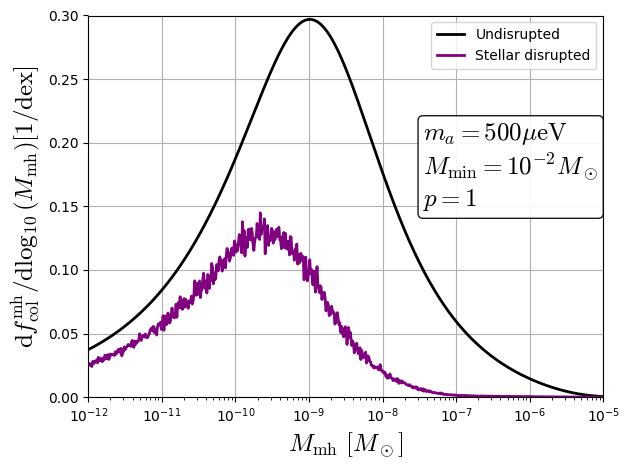

In [ ]:
# h = H0_usual_units / 100

plt.rcParams["mathtext.fontset"] = "cm"

# weights = np.zeros([num_zi_samples - 1, num_mass_samples])   # Just for reference for shape
weights_array = weights.reshape(1, (num_zi_samples - 1) * num_mass_samples)[0] #Mmin=1e2


# masses_grid = np.geomspace(M_min, M_max, num_mass_samples)   # Just for reference for shape
initial_masses_array = np.tile(masses_grid, num_zi_samples - 1)  # represents unperturbed masses

counts_unperturbed, bins_unperturbed = np.histogram(initial_masses_array, bins=masses_grid, weights=weights_array*initial_masses_array**2) # I multiplied by "weights_array" by "masses_array ** 2" because it seems that without that mutlplication,  the histogram 
                                                                                                   # program was counting very small values of the elements of "weights_array" as zero. Eventually, the weights get multiplied 
                                                                                                   # by mass**2; so, I multiplied it now itself.


counts_stellar_disruption, bins_stellar_disruption = np.histogram(final_mass_array, bins=masses_grid, weights=weights_array*final_mass_array*initial_masses_array) # I multiplied by "weights_array" by "masses_array ** 2" because it seems that without that mutlplication,  the histogram 
                                                                                                   # program was counting very small values of the elements of "weights_array" as zero. Eventually, the weights get multiplied 
                                                                                                   # by mass**2; so, I multiplied it now itself. #for the 1e-2 case, using S2023 SF, N passes through MW





font_size=18
line_width = 2


plt.semilogx(bins_unperturbed[:-1], np.log(10) / rho_m_today * counts_unperturbed, color="black", label="Undisrupted", linewidth=line_width)
plt.semilogx(bins_stellar_disruption[:-1], np.log(10) / rho_m_today * counts_stellar_disruption, color="purple", label="Stellar disrupted", linewidth=line_width)

plt.xlim(1e-12, 1e-5)
plt.ylim(0, 0.3)
plt.xlabel(r"$M_{\rm mh}\ [M_\odot]$", fontsize=font_size)
plt.ylabel(r"$\mathrm{d}f_{\rm col}^{\rm mh}/\mathrm{d}\log_{10}(M_{\rm mh}) [1/{\rm dex}]$", fontsize=font_size)
#plt.legend(fontsize=font_size)
plt.grid(True)
plt.legend()
plt.tight_layout()
# First line of text
plt.text(0.65, 0.5, r'$m_a={}\mu{{\rm eV}}$'.format(m_a) + '\n' + r'$M_{{\rm min}}=10^{-2}M_\odot$' + '\n' + r'$p=1$', 
         fontsize=font_size, transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.9, edgecolor='black', boxstyle='round,pad=0.2'))


# plt.savefig("Disrupted mass function of minihalos,ma"+str(m_a)+",Mmin 1e-2; p=1; our rgi for SF.pdf")
plt.show()

Replicating S2023 Figure (10) bottom right panel

C:\Users\ids29\AppData\Local\Temp\ipykernel_27104\1274099991.py:16: RuntimeWarning: invalid value encountered in scalar divide
  mInit_by_mFinal[i] = mass_fraction_disruption / mass_fraction_unperturbed


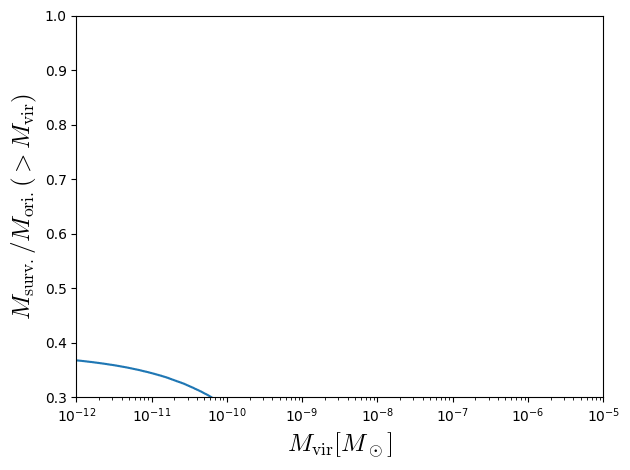

In [ ]:
# Ian's code - replicate M_final / M_initial (> M_vir) vs M_vir curve
# Neglect the RuntimeWarning. It occurs only for M_vir > 1e-5

bins_unperturbed_neglect_rightmost = bins_unperturbed[:-1]
bins_stellar_disruption_neglect_rightmost = bins_stellar_disruption[:-1]

mInit_by_mFinal = np.zeros(bins_unperturbed_neglect_rightmost.size)

for i, mass_lower_bound in enumerate(bins_unperturbed_neglect_rightmost):
    mask = bins_unperturbed_neglect_rightmost >= mass_lower_bound

    mass_fraction_unperturbed = simpson( np.log(10) / rho_m_today * counts_unperturbed[mask], x=np.log10(bins_unperturbed_neglect_rightmost[mask]))
    mass_fraction_disruption  = simpson( np.log(10) / rho_m_today * counts_stellar_disruption[mask], x=np.log10(bins_stellar_disruption_neglect_rightmost[mask]))


    mInit_by_mFinal[i] = mass_fraction_disruption / mass_fraction_unperturbed

if save_file:
    # np.save("bins", bins_unperturbed_neglect_rightmost)
    np.save(f"..\Data\File 12\M_surv by M_ori - {m_a}mueV", mInit_by_mFinal)

plt.semilogx(bins_unperturbed_neglect_rightmost, mInit_by_mFinal)
plt.xlabel(r"$M_{\rm vir} [M_\odot]$", fontsize=18)
plt.ylabel(r"$M_{\rm surv.} / M_{\rm ori.} (>M_{\rm vir})$", fontsize=18)
plt.ylim(0.3, 1)
plt.xlim(1e-12, 1e-5)
plt.tight_layout()
# plt.savefig("Replicating S2023 Fig (10) bottom right panel.pdf")
plt.show()

Generate the value of $M_{surv} / M_{ori} (> 10^{-12} hM_\odot)$

In [107]:
masses_horizontal = bins_unperturbed_neglect_rightmost
mask2 = masses_horizontal >= 1e-12
mInit_by_mFinal_greater_than_1eMinus12_Msolar = mInit_by_mFinal[mask2]
print(f"M_surv / M_ori (> 1e-12 h Msolar) = {mInit_by_mFinal_greater_than_1eMinus12_Msolar[0] * 100 :.3g}%")

M_surv / M_ori (> 1e-12 h Msolar) = 36.8%
